# Proyecto 2. Analisis Exploratorio

## Deteccion de covid en radiografias de torax

### Integrantes
#### Cristina Bautista 161260
#### Jose Block 18935
#### Esteban Cabrera 17781

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!pip install opencv-python
import cv2
import scipy.misc

!pip install pydicom
import pydicom as dicom
import os

!pip install tensorflow-io
import tensorflow as tf
import tensorflow_io as tfio

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15:

In [3]:
df1 = pd.read_csv('train_image_level.csv')
df1['StudyInstanceUID'] = df1['StudyInstanceUID'].str.rstrip(' ')
df1.StudyInstanceUID = df1.StudyInstanceUID.astype(str)
df1.StudyInstanceUID = df1.StudyInstanceUID.apply(str)

In [ ]:
df2 = pd.read_csv('train_study_level.csv')
df2['id'] = df2['id'].str.replace('_study', '')
df2['id'] = df2['id'].str.rstrip(' ')
df2.id = df2.id.astype(str)
df2.id = df2.id.apply(str)

In [ ]:
df1.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [ ]:
df1['boxes'][0]

"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]"

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
id                  6334 non-null object
boxes               4294 non-null object
label               6334 non-null object
StudyInstanceUID    6334 non-null object
dtypes: object(4)
memory usage: 198.1+ KB


In [ ]:
df2.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37bd,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
id                          6054 non-null object
Negative for Pneumonia      6054 non-null int64
Typical Appearance          6054 non-null int64
Indeterminate Appearance    6054 non-null int64
Atypical Appearance         6054 non-null int64
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


In [ ]:
df = pd.merge(df1, df2, left_on='StudyInstanceUID', right_on='id', how='inner')

In [ ]:
df.head(20)

,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,dfd9fdd85a3e,0,1,0,0
5,0022227f5adf_image,"[{'x': 1857.2065, 'y': 508.30565, 'width': 376...",opacity 1 1857.2065 508.30565 2233.23384 907.8...,84543edc24c2,84543edc24c2,0,0,1,0
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5,2fa400b873f5,1,0,0,0
7,002e9b2128d0_image,"[{'x': 276.72917, 'y': 627.42968, 'width': 910...",opacity 1 276.72917 627.42968 1187.31776 2283....,0717c8ac304f,0717c8ac304f,0,1,0,0
8,00326161e51e_image,"[{'x': 542.96057, 'y': 364.37257, 'width': 590...",opacity 1 542.96057 364.37257 1133.32317999999...,a81050391441,a81050391441,0,1,0,0
9,0044e449aae1_image,"[{'x': 1703.78756, 'y': 938.29333, 'width': 91...",opacity 1 1703.78756 938.29333 2614.8275599999...,b60f2d2cc642,b60f2d2cc642,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6334 entries, 0 to 6333
Data columns (total 9 columns):
id_x                        6334 non-null object
boxes                       4294 non-null object
label                       6334 non-null object
StudyInstanceUID            6334 non-null object
id_y                        6334 non-null object
Negative for Pneumonia      6334 non-null int64
Typical Appearance          6334 non-null int64
Indeterminate Appearance    6334 non-null int64
Atypical Appearance         6334 non-null int64
dtypes: int64(4), object(5)
memory usage: 494.8+ KB


In [ ]:
duplicate = df[df.duplicated('StudyInstanceUID')]
duplicate

,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
23,cada5310214b_image,"[{'x': 981.75034, 'y': 256.08181, 'width': 225...",opacity 1 981.75034 256.08181 1207.54099 765.2...,1a58b43cf286,1a58b43cf286,0,1,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
27,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
28,cdd9e3aaf45a_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
32,b3ffe59e37c7_image,NaN,none 1 0 0 1 1,81f6b4b343f7,81f6b4b343f7,0,1,0,0
...,...,...,...,...,...,...,...,...,...
5143,d4600028f75c_image,"[{'x': 399.19174, 'y': 226.69307, 'width': 827...",opacity 1 399.19174 226.69307 1226.20168999999...,8b18f1963aff,8b18f1963aff,0,1,0,0
5166,df3d32c8df06_image,NaN,none 1 0 0 1 1,b40f174f19a6,b40f174f19a6,0,0,1,0
5314,f4847d161683_image,"[{'x': 702.27444, 'y': 610.99231, 'width': 786...",opacity 1 702.27444 610.99231 1488.39055 1746....,6f6cf201e2e9,6f6cf201e2e9,0,1,0,0
5603,dfd9078a4c6d_image,NaN,none 1 0 0 1 1,f5c94b5db0cd,f5c94b5db0cd,0,1,0,0


In [ ]:
duplicate2 = df[df.duplicated('id_y')]
duplicate2

,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
23,cada5310214b_image,"[{'x': 981.75034, 'y': 256.08181, 'width': 225...",opacity 1 981.75034 256.08181 1207.54099 765.2...,1a58b43cf286,1a58b43cf286,0,1,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
27,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
28,cdd9e3aaf45a_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
32,b3ffe59e37c7_image,NaN,none 1 0 0 1 1,81f6b4b343f7,81f6b4b343f7,0,1,0,0
...,...,...,...,...,...,...,...,...,...
5143,d4600028f75c_image,"[{'x': 399.19174, 'y': 226.69307, 'width': 827...",opacity 1 399.19174 226.69307 1226.20168999999...,8b18f1963aff,8b18f1963aff,0,1,0,0
5166,df3d32c8df06_image,NaN,none 1 0 0 1 1,b40f174f19a6,b40f174f19a6,0,0,1,0
5314,f4847d161683_image,"[{'x': 702.27444, 'y': 610.99231, 'width': 786...",opacity 1 702.27444 610.99231 1488.39055 1746....,6f6cf201e2e9,6f6cf201e2e9,0,1,0,0
5603,dfd9078a4c6d_image,NaN,none 1 0 0 1 1,f5c94b5db0cd,f5c94b5db0cd,0,1,0,0


In [ ]:
df[df.eq('74ba8f2badcb').any(1)]

/Users/cristinabautista/Library/Python/3.7/lib/python/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
27,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
28,cdd9e3aaf45a_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0


Hallazgo:
Para un estudio pueden incluirse varias imagenes

In [ ]:
dfLabel = df.loc[df['label'] == 'none 1 0 0 1 1']
dfLabelShape = dfLabel.shape[0]
dfShape = df.shape[0]
dfShape = dfShape - dfLabelShape
dfProportion = pd.DataFrame({
    'Labels' : ['Opacity', 'None'],
    'Contador' : [dfShape, dfLabelShape],
    'Proporcion' : [(100*dfShape/df.shape[0]), (100*dfLabelShape/df.shape[0])],
},
index=['Opacity', 'None'])
dfProportion

,Labels,Contador,Proporcion
Opacity,Opacity,4294,67.792864
None,None,2040,32.207136


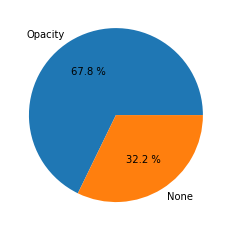

In [ ]:
plt.pie(dfProportion.Contador, labels=dfProportion.Labels, autopct="%0.1f %%")
plt.show()

In [ ]:
colNegPneu = df['Negative for Pneumonia'].value_counts()
colTypApp = df['Typical Appearance'].value_counts()
colIntApp = df['Indeterminate Appearance'].value_counts()
colAtyApp = df['Atypical Appearance'].value_counts()

In [ ]:
proportionsComplete = {
    'Nombres de Columnas' : ['Negative for Pneumonia', 'Negative for Pneumonia', 'Typical Appearance', 'Typical Appearance', 
                             'Indeterminate Appearance', 'Indeterminate Appearance', 'Atypical Appearance', 'Atypical Appearance'],
    'Metricas' : [0,1,0,1,0,1,0,1],
    'Contador' : [],
    'Proporciones' : []
}

In [ ]:
listColumns = [colNegPneu, colTypApp, colIntApp, colAtyApp]
listColumnsNames = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
listCounter = []
listProportions = []
for i in range(len(listColumnsNames)):
    a = (100*listColumns[i][0])/sum(listColumns[i])
    listCounter.append(listColumns[i][0])
    print("La proporcion de 0's en ", listColumnsNames[i], "es: \t", a)
    listProportions.append(a)
    b = (100*listColumns[i][1])/sum(listColumns[i])
    listCounter.append(listColumns[i][1])
    print("La proporcion de 1's en ", listColumnsNames[i], "es: \t", b)
    listProportions.append(b)
proportionsComplete['Contador'] = listCounter
proportionsComplete['Proporciones'] = listProportions

La proporcion de 0's en  Negative for Pneumonia es: 	 72.5923586990843
La proporcion de 1's en  Negative for Pneumonia es: 	 27.407641300915692
La proporcion de 0's en  Typical Appearance es: 	 52.526049889485314
La proporcion de 1's en  Typical Appearance es: 	 47.473950110514686
La proporcion de 0's en  Indeterminate Appearance es: 	 82.50710451531418
La proporcion de 1's en  Indeterminate Appearance es: 	 17.49289548468582
La proporcion de 0's en  Atypical Appearance es: 	 92.3744868961162
La proporcion de 1's en  Atypical Appearance es: 	 7.625513103883802


In [ ]:
# Visto en tabla
proportionsComplete = pd.DataFrame(proportionsComplete)
proportionsComplete

,Nombres de Columnas,Metricas,Contador,Proporciones
0,Negative for Pneumonia,0,4598,72.592359
1,Negative for Pneumonia,1,1736,27.407641
2,Typical Appearance,0,3327,52.526050
3,Typical Appearance,1,3007,47.473950
4,Indeterminate Appearance,0,5226,82.507105
5,Indeterminate Appearance,1,1108,17.492895
6,Atypical Appearance,0,5851,92.374487
7,Atypical Appearance,1,483,7.625513


([Text(0, 0, '4598'), Text(0, 0, '1736')],)

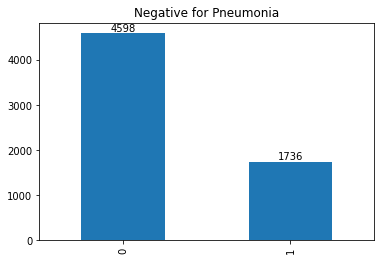

In [ ]:
ax = colNegPneu.plot.bar()
ax.set_title(listColumnsNames[0])
ax.bar_label(ax.containers[0]),

[Text(0, 0, '3327'), Text(0, 0, '3007')]

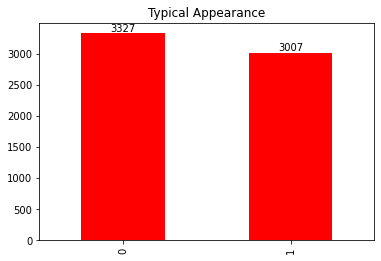

In [ ]:
ax = colTypApp.plot.bar(color='red')
ax.set_title(listColumnsNames[1])
ax.bar_label(ax.containers[0])

[Text(0, 0, '5226'), Text(0, 0, '1108')]

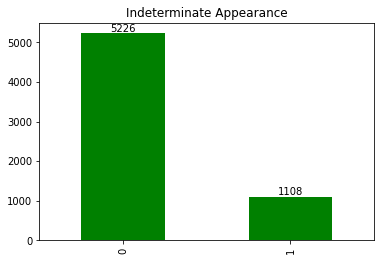

In [ ]:
ax = colIntApp.plot.bar(color='green')
ax.set_title(listColumnsNames[2])
ax.bar_label(ax.containers[0])

[Text(0, 0, '5851'), Text(0, 0, '483')]

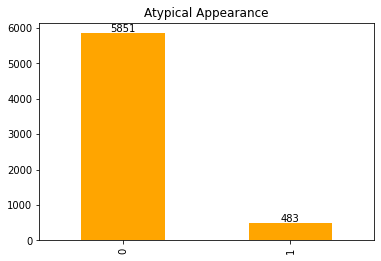

In [ ]:
ax = colAtyApp.plot.bar(color='orange')
ax.set_title(listColumnsNames[3])
ax.bar_label(ax.containers[0])

In [ ]:
df1.loc[df1['label'] == 'none 1 0 0 1 1']

,id,boxes,label,StudyInstanceUID
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286
24,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb
26,010214f9b600_image,NaN,none 1 0 0 1 1,2a7b4e669dda
...,...,...,...,...
6322,ff7659762b75_image,NaN,none 1 0 0 1 1,4aa11ef1fd38
6324,ff9f10a24c27_image,NaN,none 1 0 0 1 1,a937614104e3
6325,ffa9fef3c7bf_image,NaN,none 1 0 0 1 1,5133bbb7b75c
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06


In [ ]:
dfLabel

,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,ff0879eb20ed,1,0,0,0
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5,2fa400b873f5,1,0,0,0
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286,1a58b43cf286,0,1,0,0
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6322,ff7659762b75_image,NaN,none 1 0 0 1 1,4aa11ef1fd38,4aa11ef1fd38,1,0,0,0
6324,ff9f10a24c27_image,NaN,none 1 0 0 1 1,a937614104e3,a937614104e3,1,0,0,0
6325,ffa9fef3c7bf_image,NaN,none 1 0 0 1 1,5133bbb7b75c,5133bbb7b75c,1,0,0,0
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,7e6c68462e06,1,0,0,0


In [ ]:
colNegPneuLabel = dfLabel['Negative for Pneumonia'].value_counts()
colTypAppLabel = dfLabel['Typical Appearance'].value_counts()
colIntAppLabel = dfLabel['Indeterminate Appearance'].value_counts()
colAtyAppLabel = dfLabel['Atypical Appearance'].value_counts()

In [ ]:
proportionsCompleteNone = {
    'Nombres de Columnas' : ['Negative for Pneumonia', 'Negative for Pneumonia', 'Typical Appearance', 'Typical Appearance', 
                             'Indeterminate Appearance', 'Indeterminate Appearance', 'Atypical Appearance', 'Atypical Appearance'],
    'Metricas' : [0,1,0,1,0,1,0,1],
    'Contador' : [],
    'Proporciones' : []
}

In [ ]:
listColumns = [colNegPneuLabel, colTypAppLabel, colIntAppLabel, colAtyAppLabel]
listColumnsNames = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
listCounter = []
listProportions = []
for i in range(len(listColumnsNames)):
    a = (100*listColumns[i][0])/sum(listColumns[i])
    listCounter.append(listColumns[i][0])
    print("La proporcion de 0's en ", listColumnsNames[i], "es: \t", a)
    listProportions.append(a)
    b = (100*listColumns[i][1])/sum(listColumns[i])
    listCounter.append(listColumns[i][1])
    print("La proporcion de 1's en ", listColumnsNames[i], "es: \t", b)
    listProportions.append(b)
proportionsCompleteNone['Contador'] = listCounter
proportionsCompleteNone['Proporciones'] = listProportions

La proporcion de 0's en  Negative for Pneumonia es: 	 14.901960784313726
La proporcion de 1's en  Negative for Pneumonia es: 	 85.09803921568627
La proporcion de 0's en  Typical Appearance es: 	 92.5
La proporcion de 1's en  Typical Appearance es: 	 7.5
La proporcion de 0's en  Indeterminate Appearance es: 	 97.1078431372549
La proporcion de 1's en  Indeterminate Appearance es: 	 2.892156862745098
La proporcion de 0's en  Atypical Appearance es: 	 95.49019607843137
La proporcion de 1's en  Atypical Appearance es: 	 4.509803921568627


In [ ]:
# Visto en tabla
proportionsCompleteNone = pd.DataFrame(proportionsCompleteNone)
proportionsCompleteNone

,Nombres de Columnas,Metricas,Contador,Proporciones
0,Negative for Pneumonia,0,304,14.901961
1,Negative for Pneumonia,1,1736,85.098039
2,Typical Appearance,0,1887,92.500000
3,Typical Appearance,1,153,7.500000
4,Indeterminate Appearance,0,1981,97.107843
5,Indeterminate Appearance,1,59,2.892157
6,Atypical Appearance,0,1948,95.490196
7,Atypical Appearance,1,92,4.509804


[Text(0, 0, '1736'), Text(0, 0, '304')]

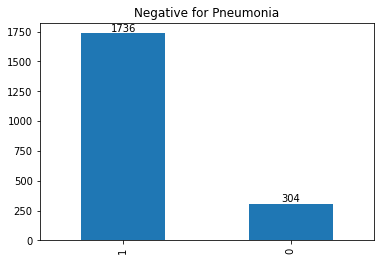

In [ ]:
ax = colNegPneuLabel.plot.bar()
ax.set_title(listColumnsNames[0])
ax.bar_label(ax.containers[0])

[Text(0, 0, '1887'), Text(0, 0, '153')]

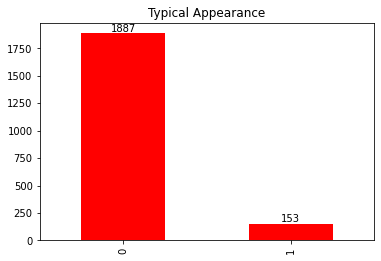

In [ ]:
ax = colTypAppLabel.plot.bar(color='red')
ax.set_title(listColumnsNames[1])
ax.bar_label(ax.containers[0])

[Text(0, 0, '1981'), Text(0, 0, '59')]

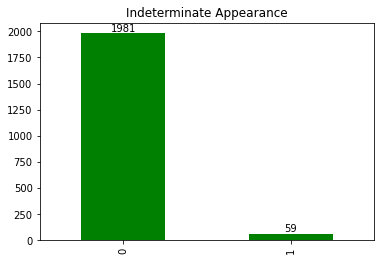

In [ ]:
ax = colIntAppLabel.plot.bar(color='green')
ax.set_title(listColumnsNames[2])
ax.bar_label(ax.containers[0])

[Text(0, 0, '1948'), Text(0, 0, '92')]

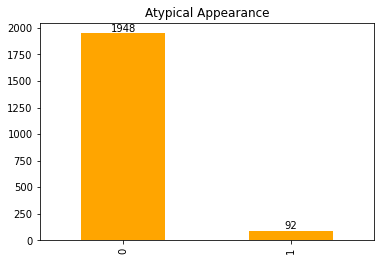

In [ ]:
ax = colAtyAppLabel.plot.bar(color='orange')
ax.set_title(listColumnsNames[3])
ax.bar_label(ax.containers[0])

Referencias: https://www.tensorflow.org/io/tutorials/dicom

W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
2021-09-11 17:49:02.665417: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19084800 exceeds 10% of free system memory.
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmMetaInfo: No Group Length available in Meta Information Header
2021-09-11 17:49:03.180247: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 15696804 exceeds 10% of free system memory.
W: DcmMetaInfo: No Group Lengt

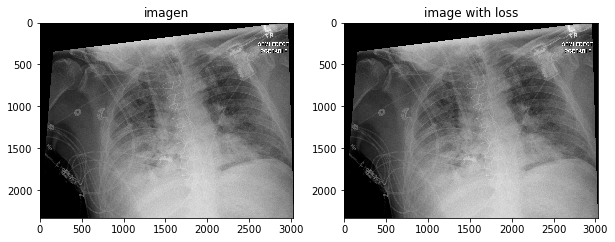

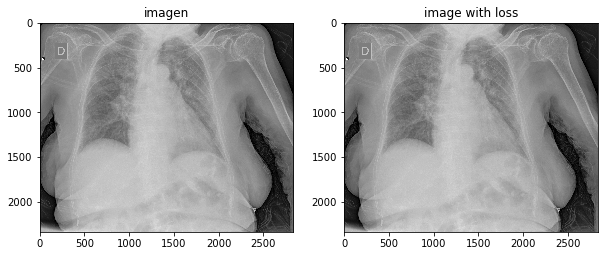

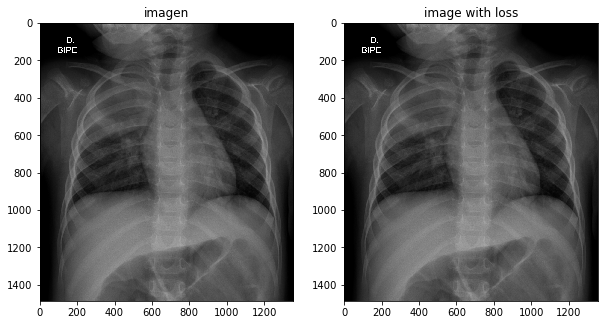

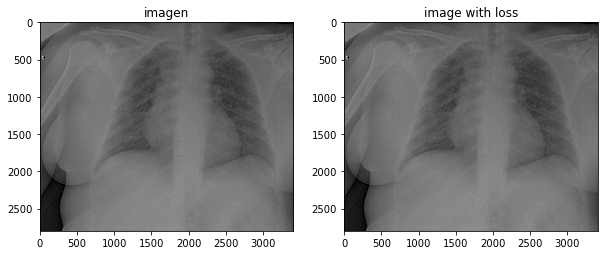

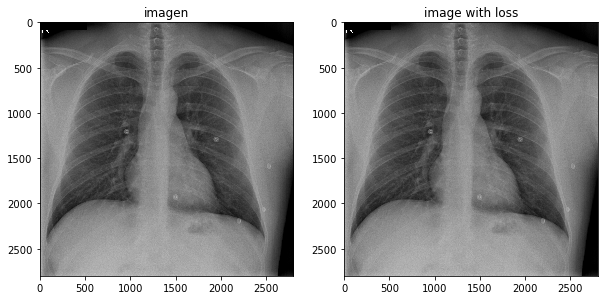

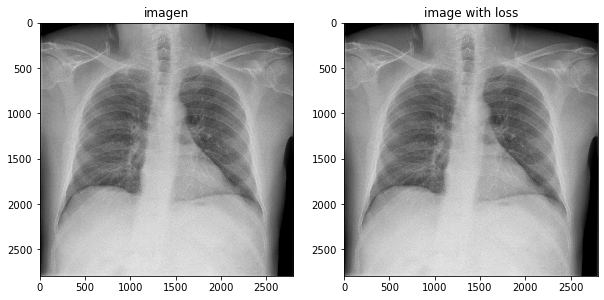

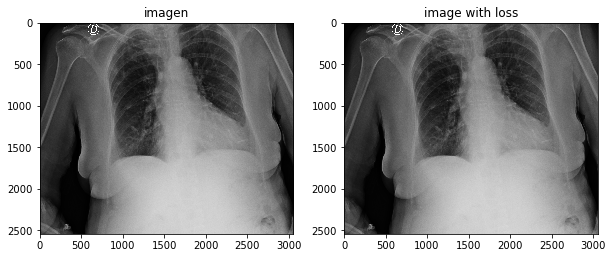

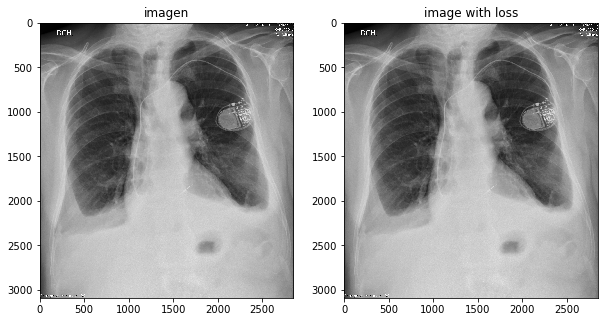

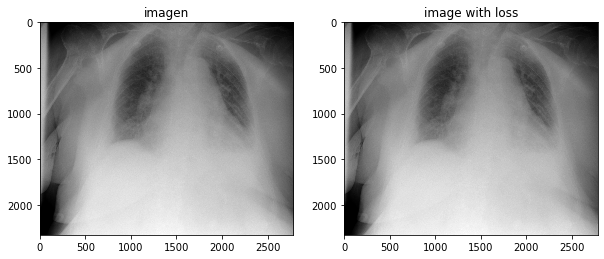

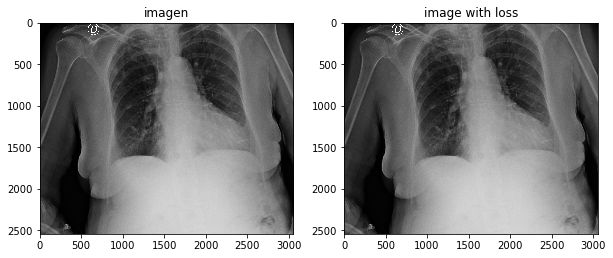

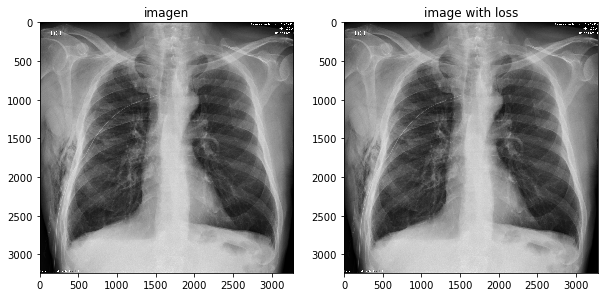

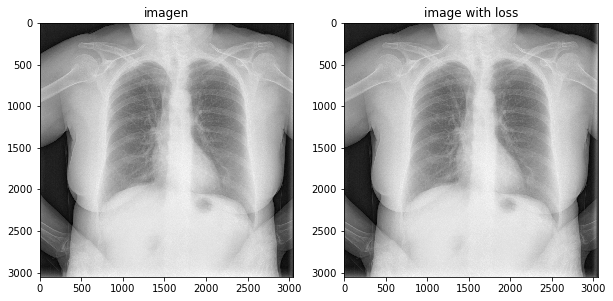

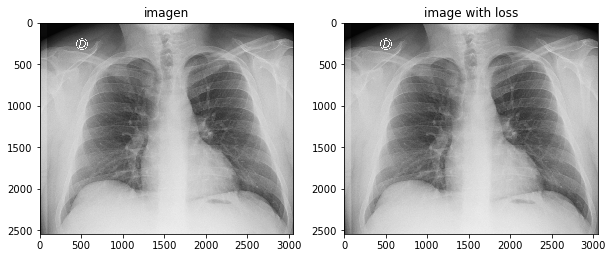

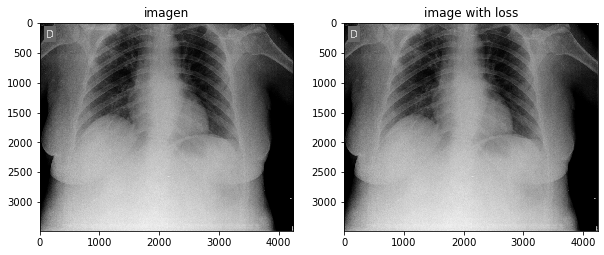

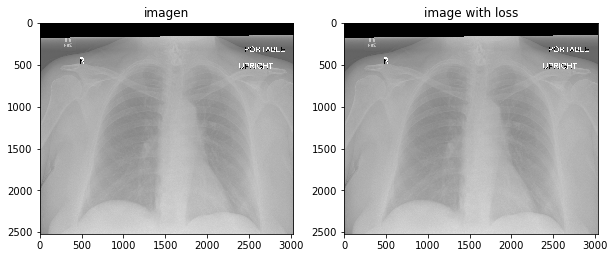

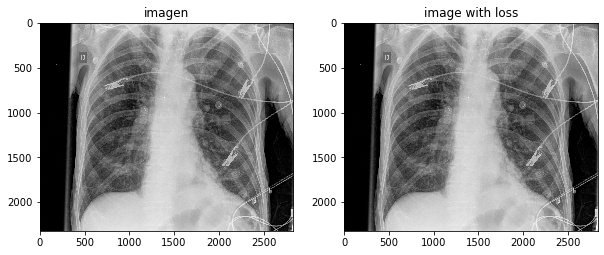

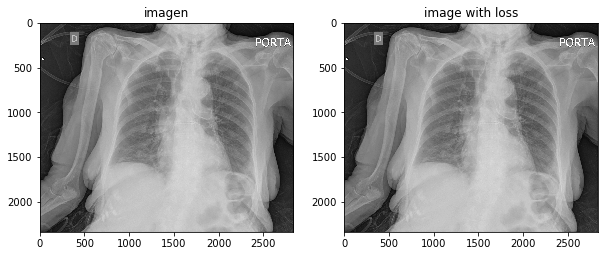

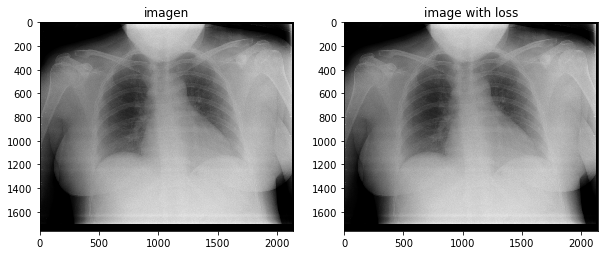

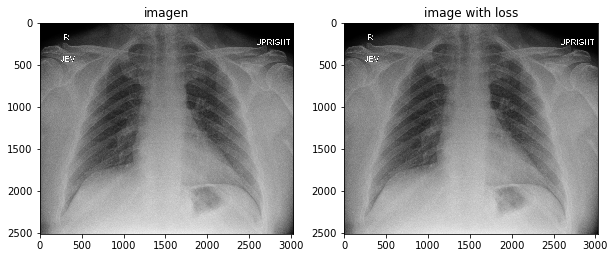

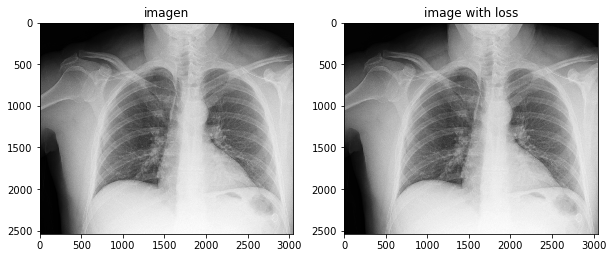

In [16]:
i = 1
while(i < 21):
    image_sample = tf.io.read_file('./Images/{}.dcm'.format(i))

    img = tfio.image.decode_dicom_image(image_sample, dtype=tf.uint16)

    sk = tfio.image.decode_dicom_image(image_sample, on_error='skip', dtype=tf.uint8)

    image_with_loss = tfio.image.decode_dicom_image(image_sample, scale='auto', on_error='lossy', dtype=tf.uint8)


    fig, axes = plt.subplots(1,2, figsize=(10,10))
    axes[0].imshow(np.squeeze(img.numpy()), cmap='gray')
    axes[0].set_title('imagen')
    axes[1].imshow(np.squeeze(image_with_loss.numpy()), cmap='gray')
    axes[1].set_title('image with loss')
    i+=1

In [34]:
def dcm2jpg (file_path):
  #Get all picture names
  c=[]
  names=os.listdir (file_path) #path
  #Separate the file name in the folder from the .dcm behind
  for name in names:
    index=name.rfind (".")
    name=name [:index]
    c.append (name)
  for files in c:
    picture_path="./Images/"+files+".dcm"
    out_path="./Images_jpg/"+files+".jpg"
    ds=pydicom.read_file (picture_path)
    img=ds.pixel_array #extract image information
    plt.imsave (out_path, img)
  print ("all is changed")
dcm2jpg ("./Images")

FileNotFoundError: [Errno 2] No such file or directory: './Images/desktop.dcm'